In [15]:
#Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, utils

# Data Loading

In [ ]:
# Download the dataset
!wget https://raw.githubusercontent.com/senyakk/Project_BACH/data/input.txt

In [10]:
# Load data
data = pd.read_csv('F.txt', delimiter ='\t', header = None)

# Data Preprocessing

In [11]:
# Normalize the voices
n_vocab = data.max().max() + 1  # global maximum to scale all voices equally

In [12]:
# Convert DataFrame to numpy array
voices = data.values

In [13]:
preprocessed_inputs = []
preprocessed_outputs = []

sequence_length = 400

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []

    for i in range(0, len(data) - seq_length, 1):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length]
        x.append(sequence)
        y.append(label)  # Pick the next note after the sequence

    return np.array(x), np.array(y)


# Create sequences for each voice
x, y = [], []
for voice in voices.T:  # Notice the transpose
    x_voice, y_voice = create_sequences(voice, sequence_length)
    x.append(x_voice)
    y.append(to_categorical(y_voice, num_classes=n_vocab))  # Do one-hot encoding separately for each voice

# Convert lists to numpy arrays and transpose to get the right shape
x = np.transpose(np.array(x), (1, 2, 0))  # should give shape (samples, sequence_length, n_voices)
y = np.transpose(np.array(y), (1, 0, 2))  # should give shape (samples, n_voices, n_vocab)

# Model Building

In [16]:
# Initialize the Model
model = Sequential()
# Add layers
model = Sequential()
model.add(LSTM(1024, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024))
model.add(Dropout(0.2))

# Separate output layer for each voice
outputs = [Dense(n_vocab, activation='softmax')(model.output) for _ in range(4)]  # Assume 4 voices
model = keras.Model(inputs=model.input, outputs=outputs)

# Compile the model
opt = Adamax(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [17]:
#Model's Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_2_input (InputLayer)      [(None, 400, 4)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 400, 1024)    4214784     ['lstm_2_input[0][0]']           
                                                                                                  
 dropout_2 (Dropout)            (None, 400, 1024)    0           ['lstm_2[0][0]']                 
                                                                                                  
 lstm_3 (LSTM)                  (None, 1024)         8392704     ['dropout_2[0][0]']              
                                                                                              

# Training

In [18]:
history = model.fit(x, [y[:, i, :] for i in range(4)], epochs=100, batch_size=64)

Epoch 1/100
54/54 [==============================] - 41s 580ms/step - loss: 9.4728 - dense_4_loss: 2.3406 - dense_5_loss: 2.5559 - dense_6_loss: 2.1532 - dense_7_loss: 2.4230
Epoch 2/100
54/54 [==============================] - 33s 606ms/step - loss: 8.2411 - dense_4_loss: 2.0971 - dense_5_loss: 2.2611 - dense_6_loss: 1.8444 - dense_7_loss: 2.0385
Epoch 3/100
54/54 [==============================] - 34s 639ms/step - loss: 7.5462 - dense_4_loss: 1.9136 - dense_5_loss: 2.0421 - dense_6_loss: 1.7063 - dense_7_loss: 1.8842
Epoch 4/100
54/54 [==============================] - 37s 679ms/step - loss: 6.8975 - dense_4_loss: 1.7412 - dense_5_loss: 1.8426 - dense_6_loss: 1.5715 - dense_7_loss: 1.7422
Epoch 5/100
54/54 [==============================] - 35s 650ms/step - loss: 6.4795 - dense_4_loss: 1.6292 - dense_5_loss: 1.7279 - dense_6_loss: 1.4935 - dense_7_loss: 1.6289
Epoch 6/100
54/54 [==============================] - 36s 664ms/step - loss: 6.0446 - dense_4_loss: 1.5102 - dense_5_loss: 1.6

# Plot Losses

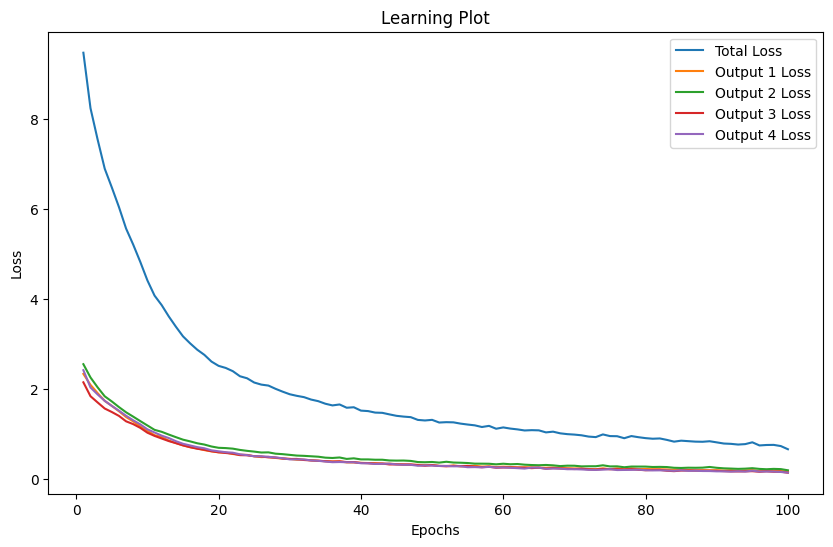

In [21]:
# Plot Losses

epoch_losses = history.history['loss']
output_losses = [history.history[f'dense_{i+4}_loss'] for i in range(4)]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Total Loss')
for i, loss in enumerate(output_losses):
    plt.plot(range(1, len(loss) + 1), loss, label=f'Output {i+1} Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Plot')
plt.legend()
plt.show()

# Saving model

In [26]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "modelV0"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)

Saving model to: models/modelV0


# Loading model

In [ ]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Generating

In [22]:
# Generate music
start = np.random.randint(0, len(x)-1)
pattern = x[start]
output = []

# Generate 400 (16x25) notes
for i in range(400):
    prediction_input = np.reshape(pattern, (1, len(pattern), x.shape[2]))  # x.shape[2] is n_voices
    prediction = model.predict(prediction_input, verbose=0)

    # Get the predicted note
    indices = [np.argmax(voice) for voice in prediction]
    output.append(indices)

    # Move the input sequence one step forward
    pattern = np.append(pattern[1:], [indices], axis=0)  # Append the note indices

In [23]:
# Write the generated sequence to G.txt
with open('G.txt', 'w') as f:
    for notes in np.array(output):  # Notice the transpose
        f.write('\t'.join([str(note) for note in notes]) + '\n')

# Make music file

In [24]:
import numpy as np
from scipy.io import wavfile

# Load the data
G = np.loadtxt('G.txt')

symbolic_length = len(G)
base_freq = 440  # Set base frequency (Hz) tuned to middle A over C,
                                    # MIDI note value of 69
sample_rate = 10000  # Samples per second
duration_per_symbol = 1/16  # In seconds. A "symbol" here means
                                      # one entry in the voice vector
ticks_per_symbol = int(sample_rate * duration_per_symbol)


def convert_voice_to_sound_vector(voice):
    sound_vector = np.zeros(symbolic_length * ticks_per_symbol)
    current_symbol = voice[0]
    start_symbol_index = 0

    for n in range(symbolic_length):
        if voice[n] != current_symbol:
            stop_symbol_index = n - 1

            covered_sound_vector_indices = np.arange((start_symbol_index - 1) * ticks_per_symbol,
                        stop_symbol_index * ticks_per_symbol)

            tone_length = len(covered_sound_vector_indices)
            frequency = base_freq * 2 ** ((current_symbol - 69) / 12)

            tone_vector = np.sin(2 * np.pi * frequency * np.arange(tone_length) / sample_rate)

            sound_vector[covered_sound_vector_indices] = tone_vector
            current_symbol = voice[n]
            start_symbol_index = n
    return sound_vector


voices = [convert_voice_to_sound_vector(G[:, i]) for i in range(4)]

# Add the sound vectors to get a multi-voice score
sound_vector = sum(voices) / 4
wavfile.write('output.wav', sample_rate, sound_vector[:].astype(np.float32))

In [25]:
import IPython

IPython.display.Audio("output.wav")